# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

*   Nombre del Alumno: **Sinahi Dionisio Ortega**
*   Materia: **Sistemas Cognitivos Artificiales**

***IMPORTANTE:*** \
**Tanto las conclusiones, como el resumen de arquitectura y el análisis de resultados se brindan en el último apartado de este reporte.**


**Introducción** \
El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo

## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras.preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (20,6)

In [3]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [4]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [5]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [6]:
Nombres = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson','charles_montgomery_burns',
           'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman','krusty_the_clown', 'lisa_simpson',
           'marge_simpson', 'milhouse_van_houten', 'moe_szyslak',
           'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [9]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

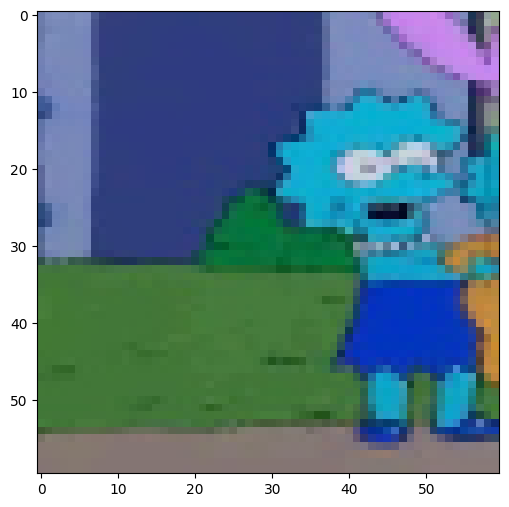

In [11]:
plt.imshow(X_t[2])

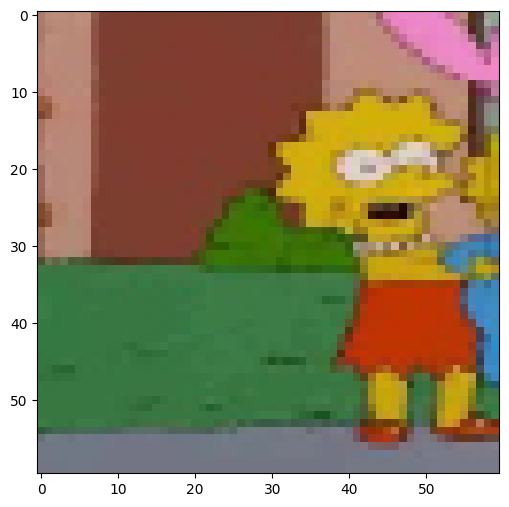

In [12]:
plt.imshow(np.flip(X_t[2], axis=-1) )

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar. **Listo**
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.**Listo**
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo? **Listo**
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema. **Listo**
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc. **Listo**
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras. **Listo**



# Analisis de datos a utilizar

Visualización de datos para un panorama general del problema a resolver

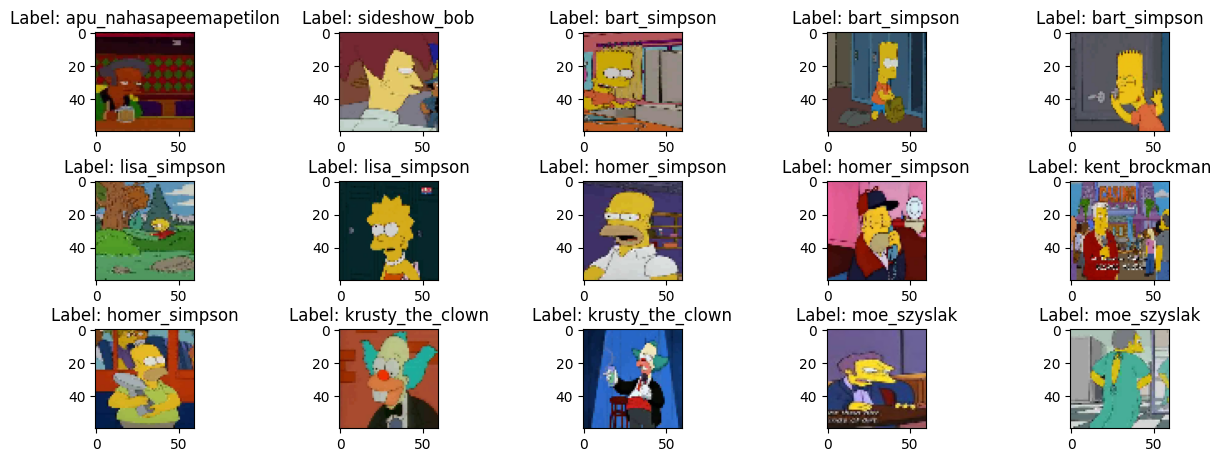

In [13]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(np.flip(X[i], axis=-1))
    plt.title(f'Label: {MAP_CHARACTERS[y[i]]}')

# Modelo 1: Modelo basico
## Primer modelo utilizando una CNN basica, con caracteristicas simples

**Caracteristicas**


1.   Reescalado
2.   Modelo basico sin dropout y batch normalization
3.   Sin Data augmentation para analizar el rendimiento



## División de datos de entrenamiento y test para todos los modelos propuestos

In [14]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
#Separación por columnas de etiquetas
ytrain1 = np.eye(len(MAP_CHARACTERS))[y_train1]
ytest1 = np.eye(len(MAP_CHARACTERS))[y_test1]

In [16]:
# Reescalado de datos 1
datagen1=  ImageDataGenerator(rescale=1./255)
testgen1 = ImageDataGenerator(rescale=1./255)

# Crear el generador de lotes para entrenamiento con aumento de datos
augmented_train_data1 = datagen1.flow(X_train1, ytrain1, batch_size=32)

# Crear el generador de lotes para prueba sin aumento de datos
test_data1 = testgen1.flow(X_test1, ytest1)

In [17]:
# Definición de Modelo 1
model1 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])

In [18]:
# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 7744)              0

In [21]:
# Entrenar el modelo
Modelhis_1= model1.fit(augmented_train_data1, epochs=30, validation_data=test_data1)

Epoch 1/30
475/475 [==============================] - 9s 9ms/step - loss: 2.0146 - accuracy: 0.3969 - val_loss: 1.4539 - val_accuracy: 0.5757
Epoch 2/30
475/475 [==============================] - 4s 8ms/step - loss: 1.2003 - accuracy: 0.6432 - val_loss: 1.0970 - val_accuracy: 0.6865
Epoch 3/30
475/475 [==============================] - 4s 9ms/step - loss: 0.8589 - accuracy: 0.7464 - val_loss: 0.9174 - val_accuracy: 0.7318
Epoch 4/30
475/475 [==============================] - 4s 7ms/step - loss: 0.6070 - accuracy: 0.8198 - val_loss: 0.8531 - val_accuracy: 0.7599
Epoch 5/30
475/475 [==============================] - 4s 8ms/step - loss: 0.4263 - accuracy: 0.8710 - val_loss: 0.8540 - val_accuracy: 0.7694
Epoch 6/30
475/475 [==============================] - 4s 9ms/step - loss: 0.2740 - accuracy: 0.9165 - val_loss: 0.8844 - val_accuracy: 0.7770
Epoch 7/30
475/475 [==============================] - 4s 7ms/step - loss: 0.1872 - accuracy: 0.9429 - val_loss: 0.9440 - val_accuracy: 0.7860
Epoch 

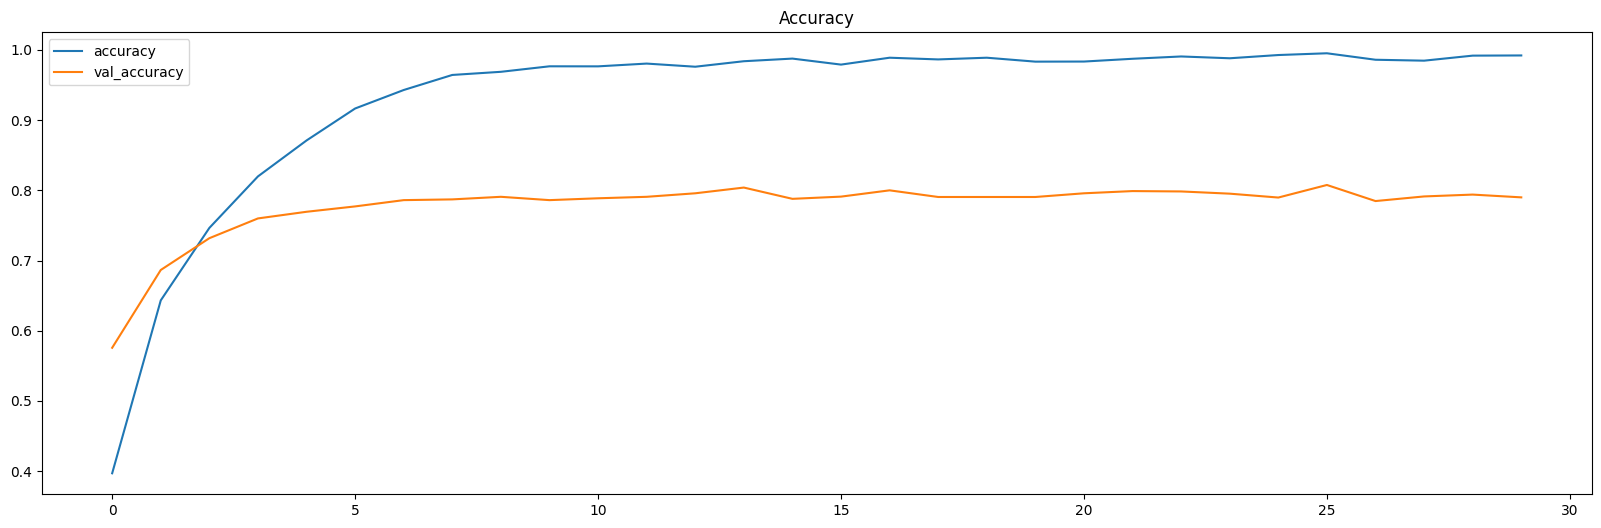

In [22]:
pd.DataFrame(Modelhis_1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

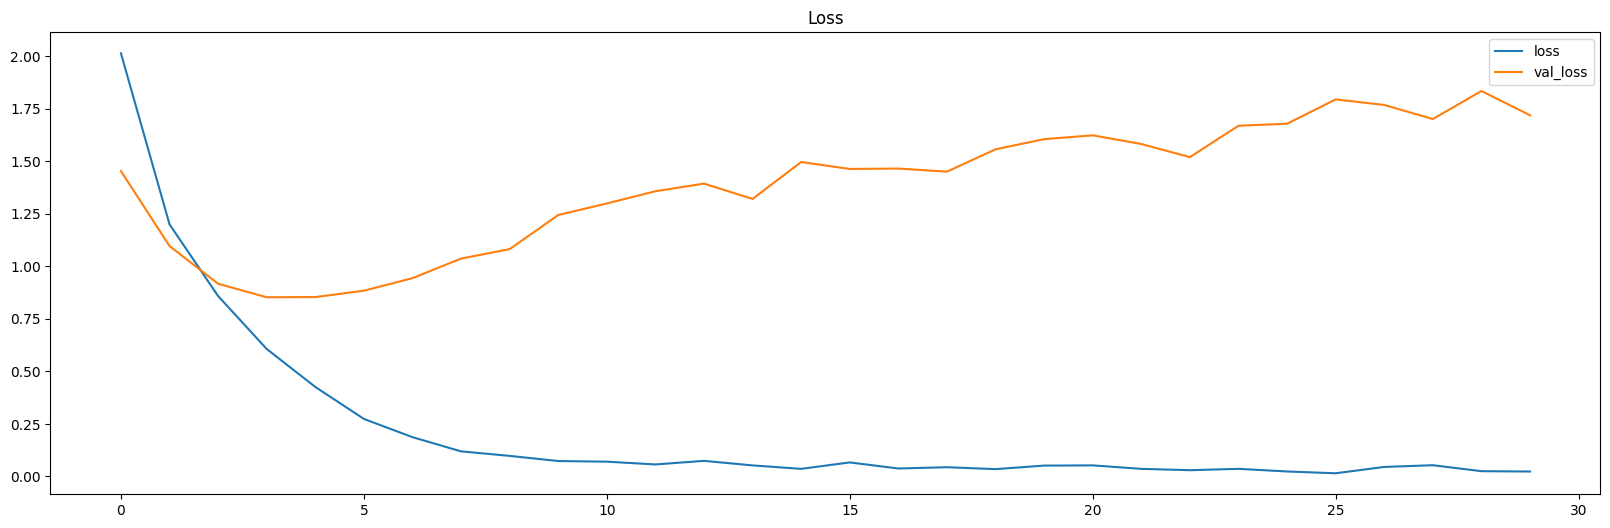

In [23]:
pd.DataFrame(Modelhis_1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Porcentaje de Accuracy de la prueba 1 con la división de datos de validación dentro de los datos de entrenamiento

In [24]:
print("Accuracy: ", Modelhis_1.history['accuracy'][-1])
print("Val_Accuracy: ", Modelhis_1.history['val_accuracy'][-1])

Accuracy:  0.9921016097068787
Val_Accuracy:  0.7899447083473206


## Resultados de TEST 1

Prueba con datos de test nuevos



In [25]:
# Predict the label of the test_images
Ypred = model1.predict(X_t/255.0)
Ypred = np.argmax(Ypred,axis=1)

# Map the label
labels = MAP_CHARACTERS
pred = [labels[k] for k in Ypred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

28/28 [==============================] - 0s 6ms/step
The first 5 predictions: ['comic_book_guy', 'edna_krabappel', 'lisa_simpson', 'sideshow_bob', 'sideshow_bob']


In [26]:
#Accuracy con datos nuevos:
acc = accuracy_score(y_t, Ypred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 94.61%


In [27]:
class_report = classification_report(y_t, Ypred, target_names=Nombres, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.90      0.91        48
  apu_nahasapeemapetilon       1.00      0.94      0.97        50
            bart_simpson       0.89      0.94      0.91        50
charles_montgomery_burns       0.92      0.92      0.92        48
            chief_wiggum       0.94      0.96      0.95        50
          comic_book_guy       0.96      0.92      0.94        49
          edna_krabappel       0.94      0.90      0.92        50
           homer_simpson       0.86      0.98      0.92        50
           kent_brockman       0.98      0.94      0.96        50
        krusty_the_clown       0.96      0.94      0.95        50
            lisa_simpson       0.98      0.86      0.91        50
           marge_simpson       0.98      0.96      0.97        50
     milhouse_van_houten       0.96      0.96      0.96        49
             moe_szyslak       0.94      1.00      0.97        50
         

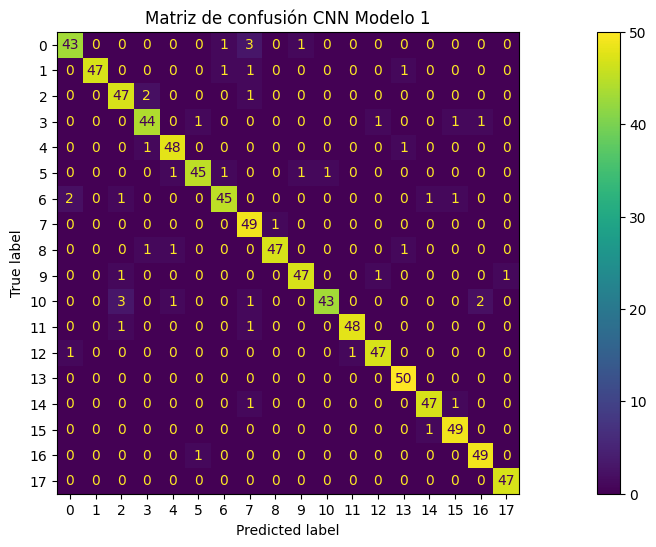

In [28]:
cm_nn=confusion_matrix(
    y_true = y_t,
    y_pred = Ypred
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp.plot()
plt.title("Matriz de confusión CNN Modelo 1")
plt.show()

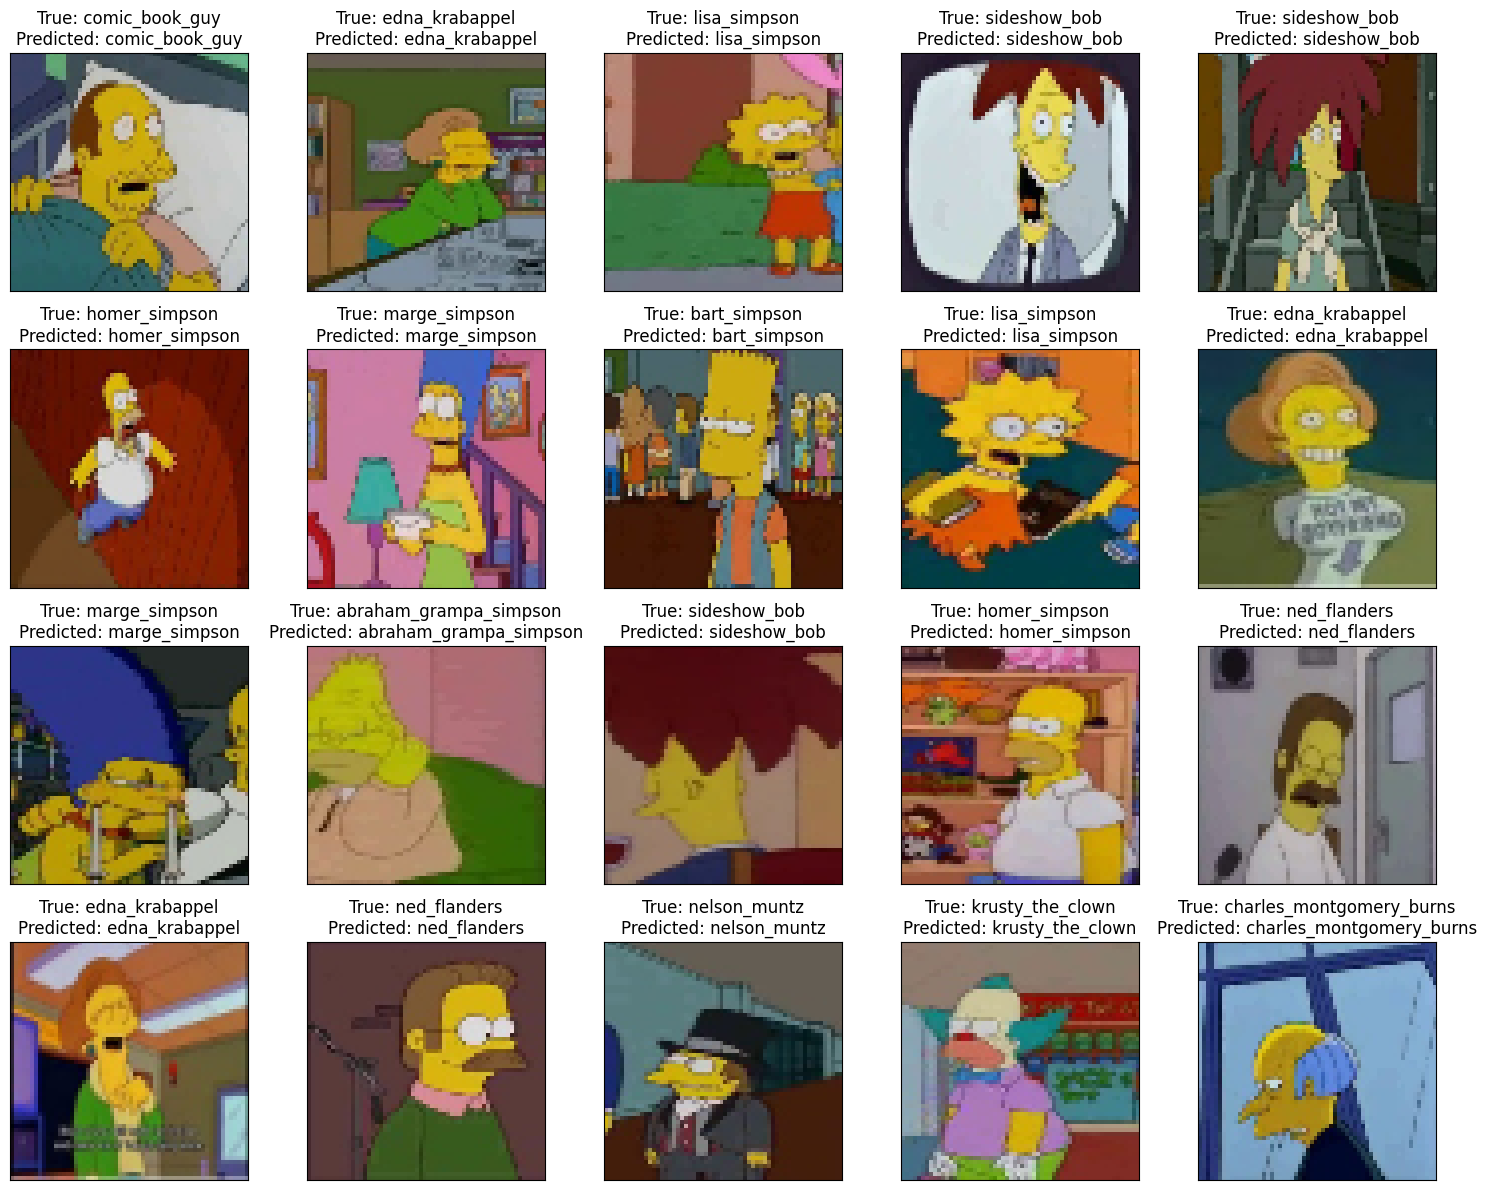

In [29]:
# Display 15 imágenes del conjunto de datos con sus etiquetas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flip(X_t[i], axis=-1))  # Utiliza X_test en lugar de plt.imread(test_df.Filepath.iloc[i])
    true_label = labels[y_t[i]]  # Convertir la etiqueta a una cadena
    predicted_label = labels[Ypred[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Conclusión 1
Modelo básico con buen desempeño en test pero deficiente en validación de entrenamiento

# Modelo 2: Modelo mejorado

**Caracteristicas**
* Reescalado
* Sin Data Augmentation
* Modelo con capas dropout y batch normalization



## División de datos de entrenamiento y test para todos los modelos propuestos

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
ytrain2 = np.eye(len(MAP_CHARACTERS))[y_train2]
ytest2 = np.eye(len(MAP_CHARACTERS))[y_test2]

In [32]:
# Normalización de datos 2
datagen2 = ImageDataGenerator(rescale=1./255)

#Escalado de datos de test
testgen2 = ImageDataGenerator(rescale=1./255)


In [33]:
datagen2.fit(X_train2)
testgen2.fit(X_test2)

In [34]:
# Aplicar el aumento de datos a las variables de entrenamiento
#Ajustar los generadores
datagen2.fit(X_train2)
testgen2.fit(X_test2)

# Crear generador de lotes para entrenamiento con aumento de datos
augmented_train_data2 = datagen2.flow(X_train2, ytrain2, batch_size=32)

# Crear generador de lotes para prueba sin aumento de datos
test_data2 = testgen2.flow(X_test2, ytest2)

In [35]:
# Crear el modelo
model2 = tf.keras.models.Sequential([
    layers.Conv2D(64, (3, 3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])

In [36]:
# Compilar el modelo
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 58, 58, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 128)     

In [38]:
# Entrenar el modelo
Modelhis_2= model2.fit(augmented_train_data2, epochs=30, validation_data=test_data2)

Epoch 1/30
475/475 [==============================] - 12s 18ms/step - loss: 1.8503 - accuracy: 0.4834 - val_loss: 1.8225 - val_accuracy: 0.4528
Epoch 2/30
475/475 [==============================] - 8s 16ms/step - loss: 1.0264 - accuracy: 0.6985 - val_loss: 2.3655 - val_accuracy: 0.4980
Epoch 3/30
475/475 [==============================] - 8s 17ms/step - loss: 0.6753 - accuracy: 0.7939 - val_loss: 0.6751 - val_accuracy: 0.7986
Epoch 4/30
475/475 [==============================] - 8s 17ms/step - loss: 0.4884 - accuracy: 0.8512 - val_loss: 0.7038 - val_accuracy: 0.7989
Epoch 5/30
475/475 [==============================] - 8s 16ms/step - loss: 0.3602 - accuracy: 0.8888 - val_loss: 0.7222 - val_accuracy: 0.7968
Epoch 6/30
475/475 [==============================] - 8s 17ms/step - loss: 0.3013 - accuracy: 0.9041 - val_loss: 0.6636 - val_accuracy: 0.8226
Epoch 7/30
475/475 [==============================] - 8s 17ms/step - loss: 0.2242 - accuracy: 0.9282 - val_loss: 0.5712 - val_accuracy: 0.844

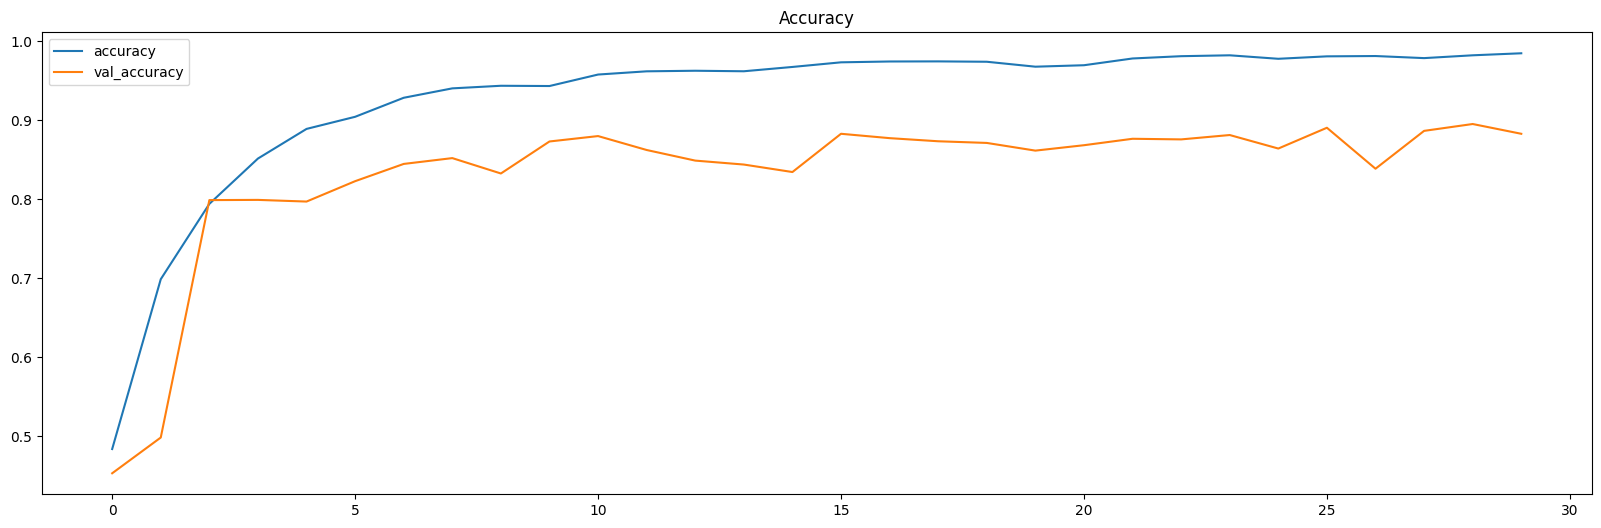

In [39]:
pd.DataFrame(Modelhis_2.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

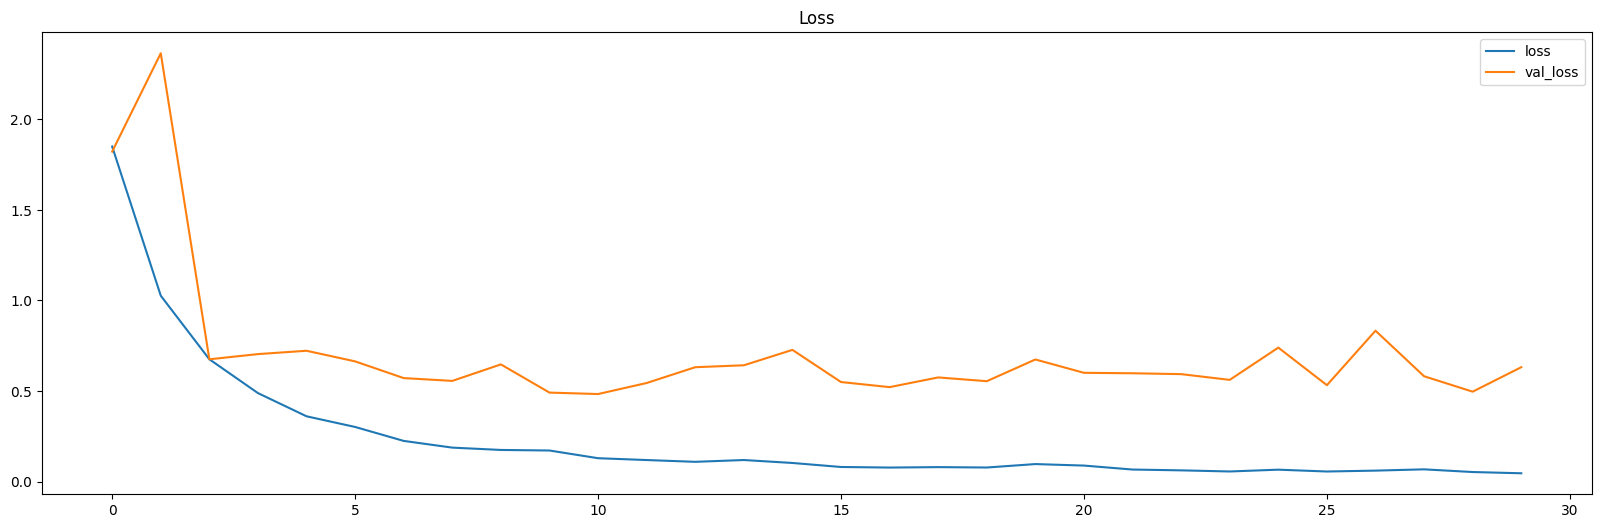

In [40]:
pd.DataFrame(Modelhis_2.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Porcentaje de Accuracy de la prueba 1 con la división de datos de validación dentro de los datos de entrenamiento

In [41]:
print("Accuracy: ", Modelhis_2.history['accuracy'][-1])
print("Val_Accuracy: ", Modelhis_2.history['val_accuracy'][-1])

Accuracy:  0.984532356262207
Val_Accuracy:  0.8826006650924683


## Resultados prueba 2

Prueba con datos de test nuevos



In [42]:
# Predict the label of the test_images
Ypred2 = model2.predict(X_t/255.0)
Ypred2 = np.argmax(Ypred2,axis=1)

# Map the label
labels = MAP_CHARACTERS
pred2 = [labels[k] for k in Ypred2]

# Display the result
print(f'The first 5 predictions: {pred2[:5]}')

28/28 [==============================] - 0s 7ms/step
The first 5 predictions: ['comic_book_guy', 'edna_krabappel', 'lisa_simpson', 'sideshow_bob', 'sideshow_bob']


In [43]:
#Accuracy con datos nuevos:
acc = accuracy_score(y_t, Ypred2)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 96.52%


In [44]:
class_report = classification_report(y_t, Ypred2, target_names=Nombres, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.90      0.95        48
  apu_nahasapeemapetilon       0.98      0.94      0.96        50
            bart_simpson       0.98      0.88      0.93        50
charles_montgomery_burns       0.92      0.98      0.95        48
            chief_wiggum       0.98      0.98      0.98        50
          comic_book_guy       1.00      1.00      1.00        49
          edna_krabappel       0.98      0.90      0.94        50
           homer_simpson       0.89      0.98      0.93        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.94      0.94      0.94        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       1.00      1.00      1.00        49
             moe_szyslak       0.91      1.00      0.95        50
         

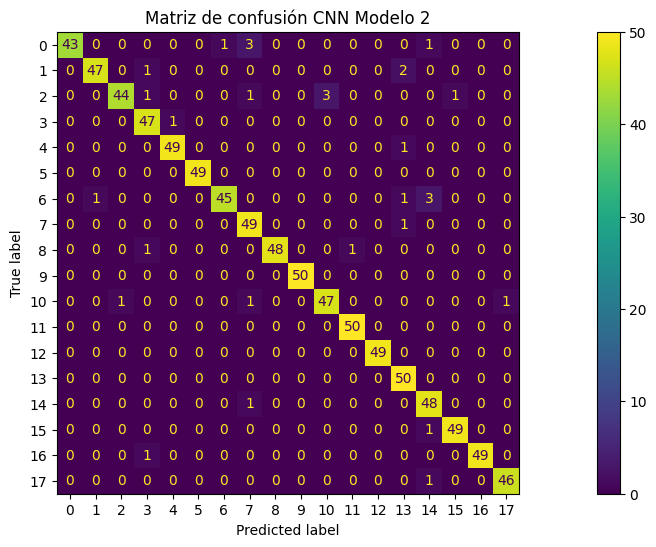

In [99]:
cm_nn2=confusion_matrix(
    y_true = y_t,
    y_pred = Ypred2
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn2)
disp.plot()
plt.title("Matriz de confusión CNN Modelo 2")
plt.show()

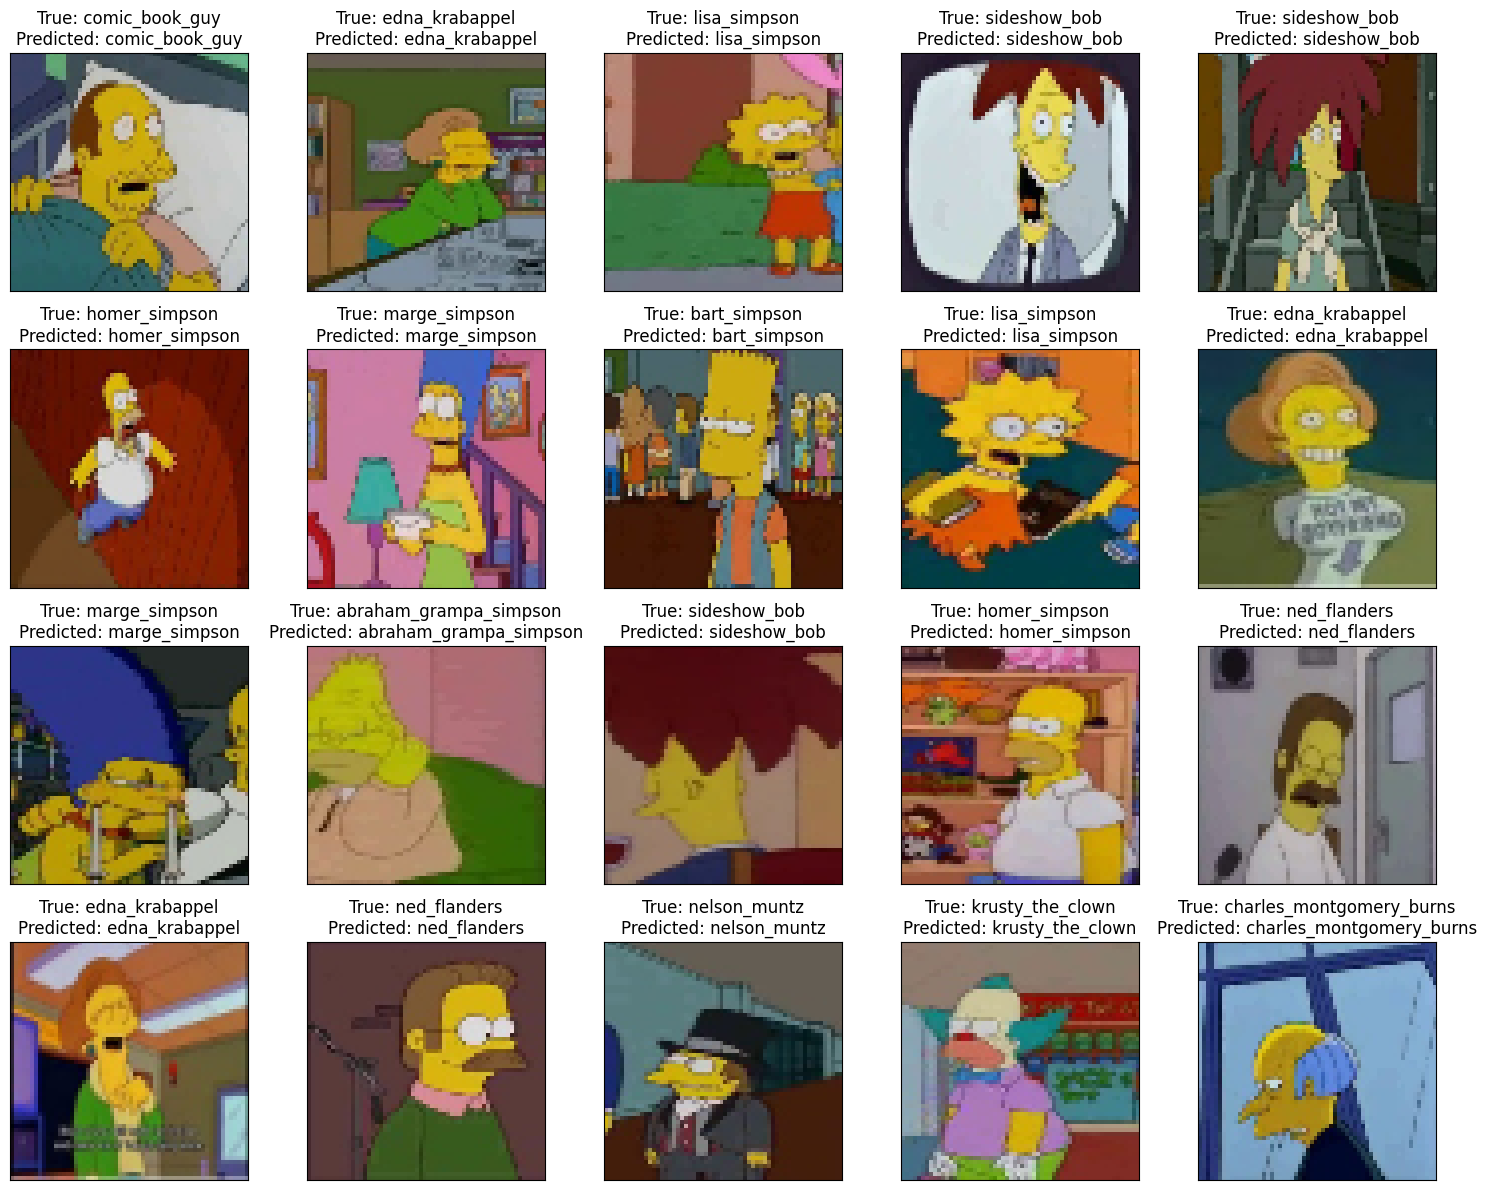

In [46]:
# Display 15 imágenes del conjunto de datos con sus etiquetas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flip(X_t[i], axis=-1))  # Utiliza X_test en lugar de plt.imread(test_df.Filepath.iloc[i])
    true_label = labels[y_t[i]]  # Convertir la etiqueta a una cadena
    predicted_label = labels[Ypred2[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Conclusión 2
Buen modelo, gran ajuste, entrenamiento rápido, pero sin aumento de datos.

# Modelo 3: Modelo 2 Con Datos aumentados

**Caracteristicas**
* Reescalado
* Data Augmentation
* Modelo con capas dropout y batch normalization



## División de datos de entrenamiento y test para todos los modelos propuestos

In [47]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.20, random_state=42)

In [48]:
ytrain3 = np.eye(len(MAP_CHARACTERS))[y_train2]
ytest3 = np.eye(len(MAP_CHARACTERS))[y_test2]

In [49]:
# Reescalado de datos 1
#Aumento de datos de entrenamiento
datagen3 = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

#Escalado de datos de test
testgen3 = ImageDataGenerator(rescale=1./255)


In [50]:
# Aplicar el aumento de datos a las variables de entrenamiento
#Ajustar los generadores
datagen3.fit(X_train3)
testgen3.fit(X_test3)

# Crear generador de lotes para entrenamiento con aumento de datos
augmented_train_data3 = datagen3.flow(X_train3, ytrain3, batch_size=32)

# Crear generador de lotes para prueba sin aumento de datos
test_data3 = testgen3.flow(X_test3, ytest3)

In [51]:
# Crear el modelo
model3 = tf.keras.models.Sequential([
    layers.Conv2D(64, (3, 3), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])

In [52]:
# Compilar el modelo
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 58, 64)        1792      
                                                                 
 batch_normalization_4 (Batc  (None, 58, 58, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 29, 29, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 batch_normalization_5 (Batc  (None, 27, 27, 128)     

In [54]:
# Entrenar el modelo
Modelhis_3= model3.fit(augmented_train_data3, epochs=30, validation_data=test_data3)

Epoch 1/30
475/475 [==============================] - 27s 47ms/step - loss: 2.4687 - accuracy: 0.2987 - val_loss: 2.3399 - val_accuracy: 0.3103
Epoch 2/30
475/475 [==============================] - 23s 48ms/step - loss: 1.7135 - accuracy: 0.4864 - val_loss: 1.1286 - val_accuracy: 0.6489
Epoch 3/30
475/475 [==============================] - 23s 48ms/step - loss: 1.3105 - accuracy: 0.6017 - val_loss: 1.0007 - val_accuracy: 0.7044
Epoch 4/30
475/475 [==============================] - 23s 48ms/step - loss: 1.0833 - accuracy: 0.6706 - val_loss: 0.7357 - val_accuracy: 0.7757
Epoch 5/30
475/475 [==============================] - 23s 47ms/step - loss: 0.9613 - accuracy: 0.7075 - val_loss: 0.6550 - val_accuracy: 0.8021
Epoch 6/30
475/475 [==============================] - 22s 46ms/step - loss: 0.8929 - accuracy: 0.7262 - val_loss: 0.5452 - val_accuracy: 0.8307
Epoch 7/30
475/475 [==============================] - 24s 50ms/step - loss: 0.8179 - accuracy: 0.7526 - val_loss: 0.6125 - val_accuracy:

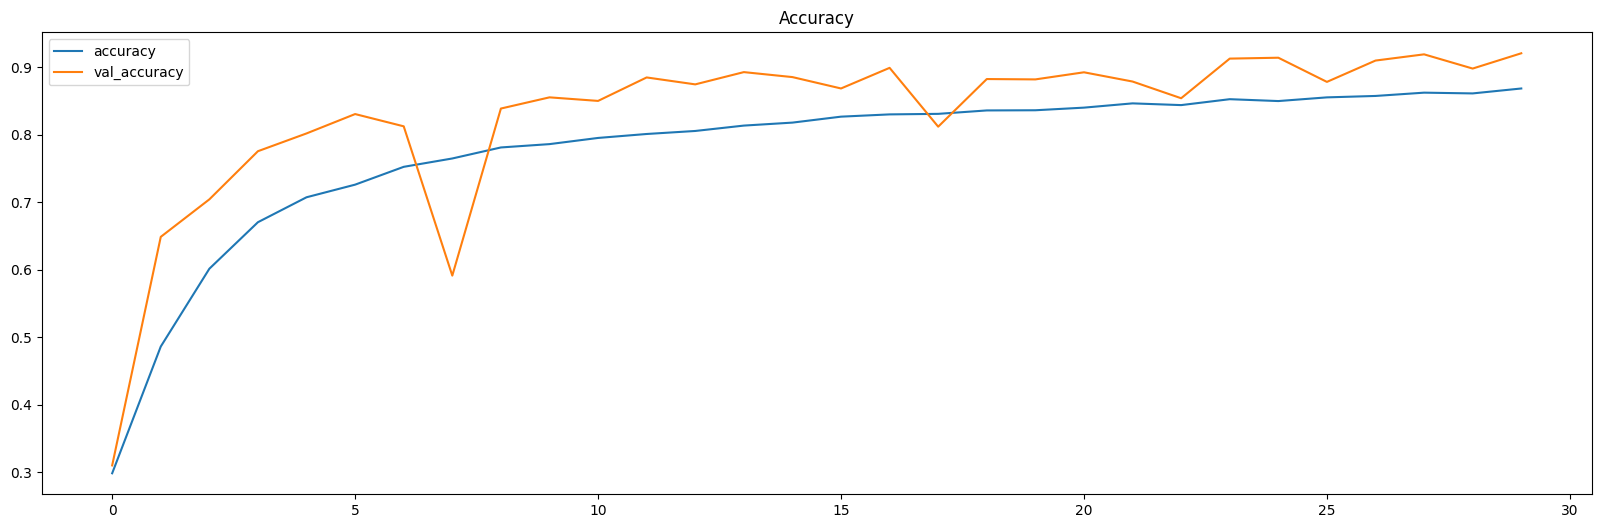

In [55]:
pd.DataFrame(Modelhis_3.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

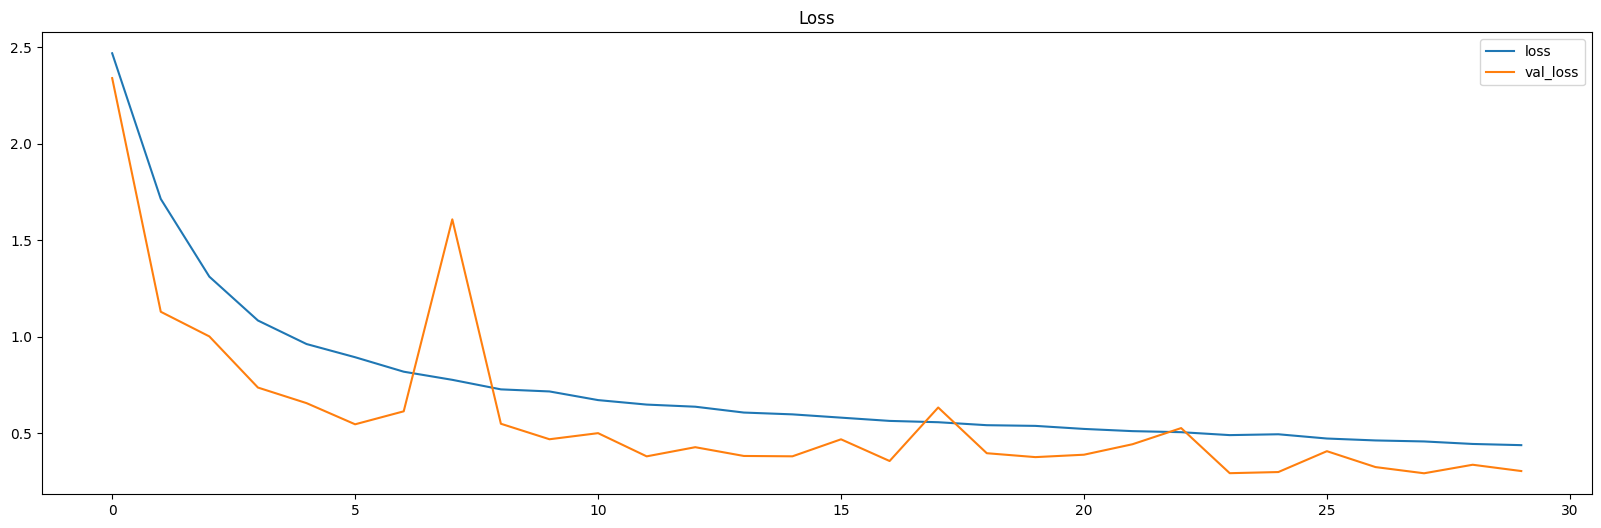

In [56]:
pd.DataFrame(Modelhis_3.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Porcentaje de Accuracy de la prueba 3 con la división de datos de validación dentro de los datos de entrenamiento

In [57]:
print("Accuracy: ", Modelhis_3.history['accuracy'][-1])
print("Val_Accuracy: ", Modelhis_3.history['val_accuracy'][-1])

Accuracy:  0.8686237335205078
Val_Accuracy:  0.9207686185836792


## Resultados prueba 3

Prueba con datos de test nuevos



In [58]:
# Predict the label of the test_images
Ypred3 = model2.predict(X_t/255)
Ypred3 = np.argmax(Ypred3,axis=1)

# Map the label
labels = MAP_CHARACTERS
pred3 = [labels[k] for k in Ypred3]

# Display the result
print(f'The first 5 predictions: {pred3[:5]}')

28/28 [==============================] - 0s 4ms/step
The first 5 predictions: ['comic_book_guy', 'edna_krabappel', 'lisa_simpson', 'sideshow_bob', 'sideshow_bob']


In [59]:
#Accuracy con datos nuevos:
acc = accuracy_score(y_t, Ypred3)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 96.52%


In [60]:
class_report = classification_report(y_t, Ypred3, target_names=Nombres, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.90      0.95        48
  apu_nahasapeemapetilon       0.98      0.94      0.96        50
            bart_simpson       0.98      0.88      0.93        50
charles_montgomery_burns       0.92      0.98      0.95        48
            chief_wiggum       0.98      0.98      0.98        50
          comic_book_guy       1.00      1.00      1.00        49
          edna_krabappel       0.98      0.90      0.94        50
           homer_simpson       0.89      0.98      0.93        50
           kent_brockman       1.00      0.96      0.98        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.94      0.94      0.94        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       1.00      1.00      1.00        49
             moe_szyslak       0.91      1.00      0.95        50
         

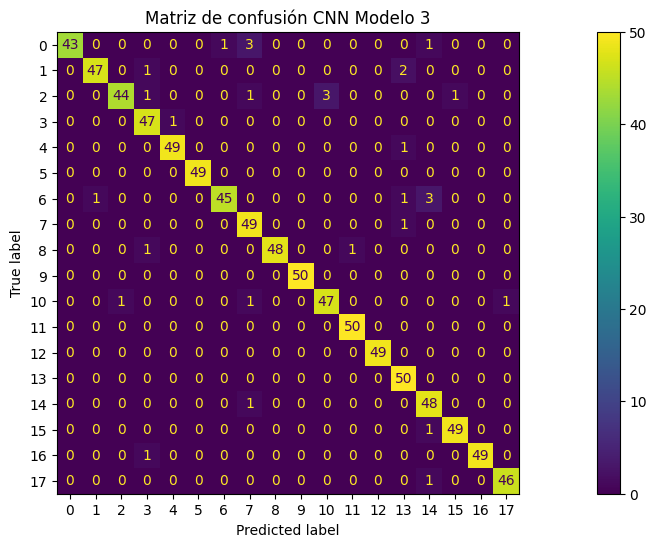

In [61]:
cm_nn3=confusion_matrix(
    y_true = y_t,
    y_pred = Ypred3
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn3)
disp.plot()
plt.title("Matriz de confusión CNN Modelo 3")
plt.show()

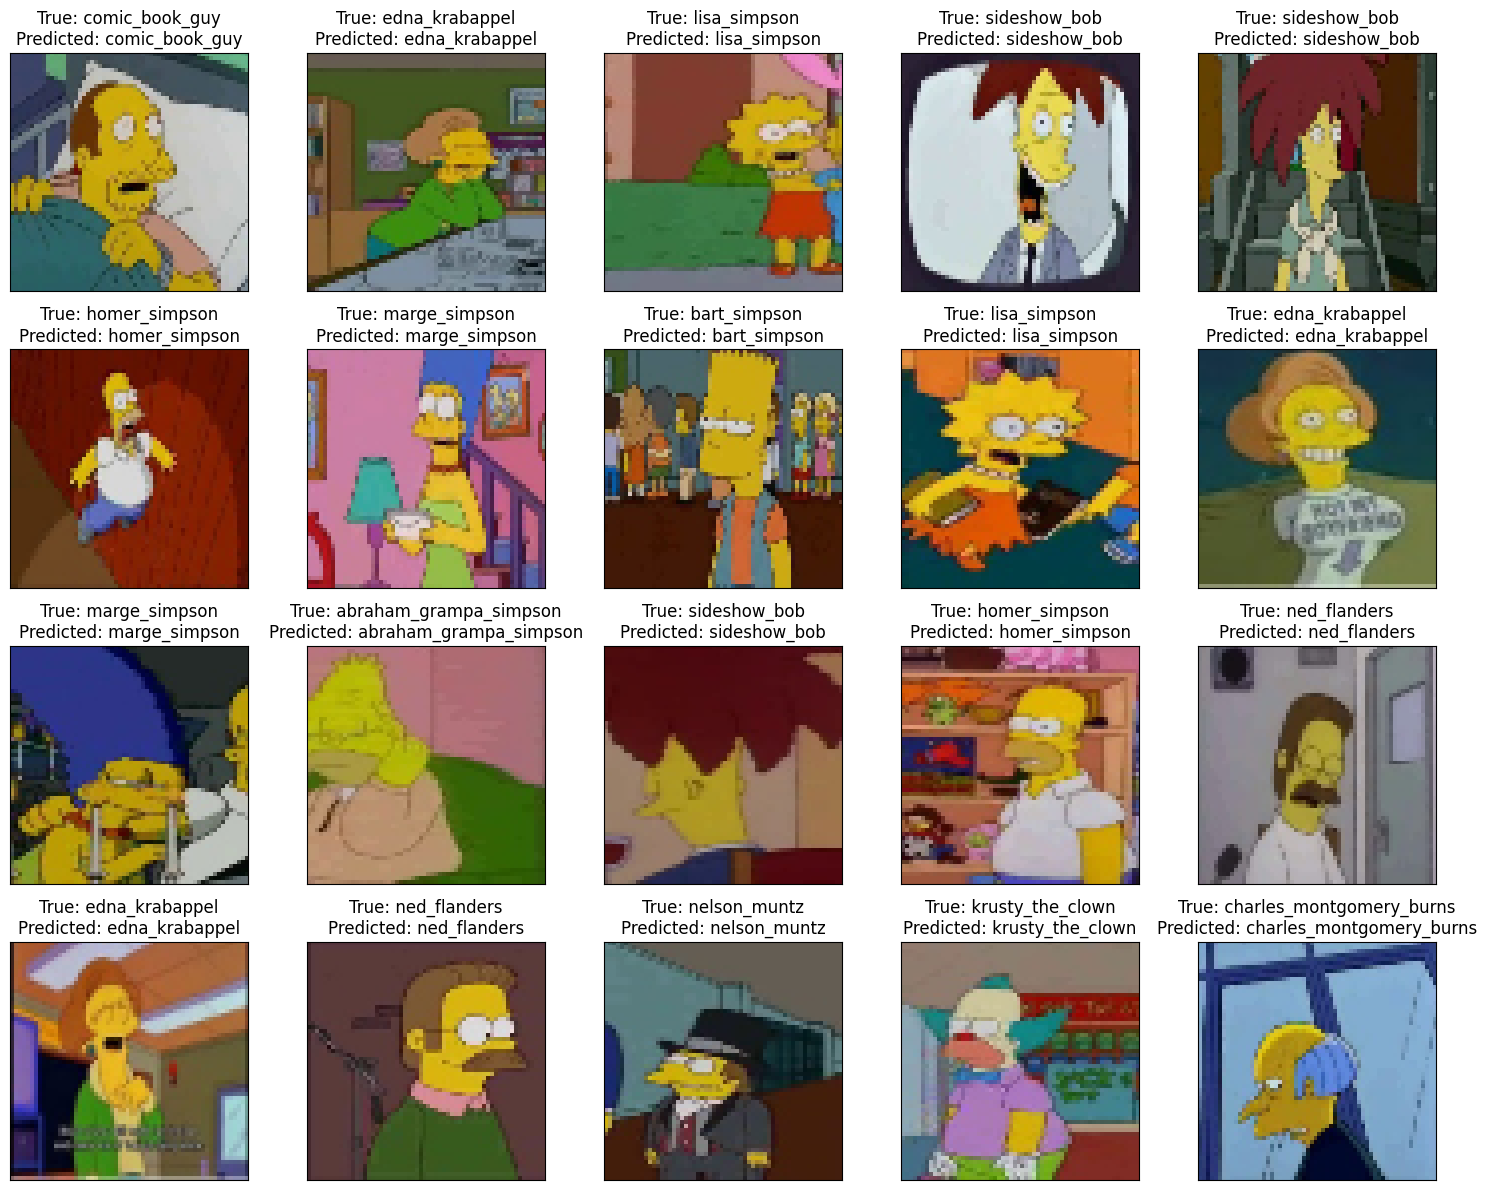

In [62]:
# Display 15 imágenes del conjunto de datos con sus etiquetas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flip(X_t[i], axis=-1))  # Utiliza X_test en lugar de plt.imread(test_df.Filepath.iloc[i])
    true_label = labels[y_t[i]]  # Convertir la etiqueta a una cadena
    predicted_label = labels[Ypred3[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Conclusión 3
**Modelo Recomendado** El modelo se ajusta con buena exactitud a los datos de test con buenos rendimientos en entrenamiento y considerando un aumento de datos en su estructura lo que da mejoras en el reconocimiento de patrones.

# Modelo 4: Modelo complejo
## Modelo utilizando una CNN con más capas, con caracteristicas más amplias

**Caracteristicas**


1.   Reescalado
2.   Modelo más complejo con dropout y batch normalization
3.   Aplicando Data augmentation
4.   Se aplica callback para detener el entrenamiento
5.   Se aplica regularización L2


In [63]:
#Separación de datos para prueba
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.20, random_state=42)

### Data Augmentation

In [64]:
#Aumento de datos de entrenamiento
datagen4 = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#Escalado de datos de test
testgen4 = ImageDataGenerator(rescale=1./255)

Codificamos etiquetas de salida con un segundo metodo

In [65]:
# codificar etiquetas de salida
Ytrain4 = tf.keras.utils.to_categorical(y_train4, num_classes=18)
Ytest4 = tf.keras.utils.to_categorical(y_test4, num_classes=18)

In [66]:
# Aplicar el aumento de datos a las variables de entrenamiento
# Ajustar los generadores de datos
datagen4.fit(X_train4)
testgen4.fit(X_test4)

# Crear generador de lotes para entrenamiento con aumento de datos
augmented_train_data4 = datagen4.flow(X_train4, Ytrain4, batch_size=32)

# Crear generador de lotes para prueba sin aumento de datos
test_data4 = testgen4.flow(X_test4, Ytest4)

Aplicamos el data augmentation a los valores de entrenamiento y test

### Callback

In [67]:
#Define a Callback class that stos training once accuracy reaches 92%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\n Reached 90% val_accuracy so cancelling training!")
      self.model.stop_training= True

### Definimos el modelo aplicando

*   Dropout de 0.3
*   Batch Normalization
*   Regularization L2



In [68]:
model4 = keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)),
    layers.Conv2D(32, (3,3), kernel_regularizer=regularizers.l2(0.0001), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)),
    layers.Conv2D(64, (3,3),kernel_regularizer=regularizers.l2(0.0001), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64,(3,3),  activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l2(0.0001), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)),
    layers.Conv2D(256, (3,3),kernel_regularizer=regularizers.l2(0.0001), activation='relu', padding="same"),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])

In [100]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 58, 58, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 19, 19, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 19, 19, 32)       128       
 hNormalization)                                                 
                                                      

In [70]:
# Compilar el modelo
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
#Aplicar el modelo con Callback
callbacks= myCallback()
Modelhis_4 = model4.fit(augmented_train_data4, epochs=100, validation_data=test_data4, callbacks=[callbacks])

Epoch 1/100
475/475 [==============================] - 27s 46ms/step - loss: 2.1437 - accuracy: 0.3575 - val_loss: 2.1117 - val_accuracy: 0.3698
Epoch 2/100
475/475 [==============================] - 21s 45ms/step - loss: 1.4871 - accuracy: 0.5590 - val_loss: 1.4090 - val_accuracy: 0.5820
Epoch 3/100
475/475 [==============================] - 20s 43ms/step - loss: 1.2135 - accuracy: 0.6448 - val_loss: 1.0997 - val_accuracy: 0.6931
Epoch 4/100
475/475 [==============================] - 21s 45ms/step - loss: 1.0862 - accuracy: 0.6845 - val_loss: 1.0235 - val_accuracy: 0.7076
Epoch 5/100
475/475 [==============================] - 21s 43ms/step - loss: 0.9862 - accuracy: 0.7234 - val_loss: 1.0946 - val_accuracy: 0.6894
Epoch 6/100
475/475 [==============================] - 21s 45ms/step - loss: 0.9168 - accuracy: 0.7472 - val_loss: 0.9004 - val_accuracy: 0.7486
Epoch 7/100
475/475 [==============================] - 21s 45ms/step - loss: 0.8758 - accuracy: 0.7647 - val_loss: 0.7866 - val_ac

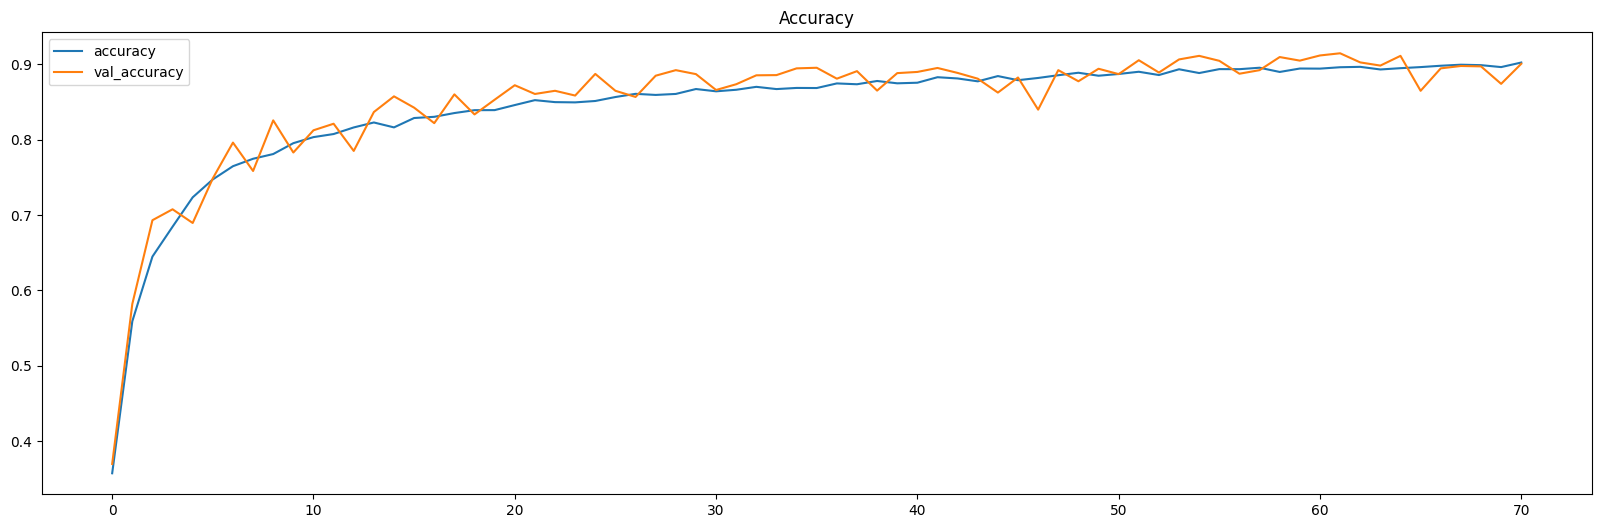

In [72]:
pd.DataFrame(Modelhis_4.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

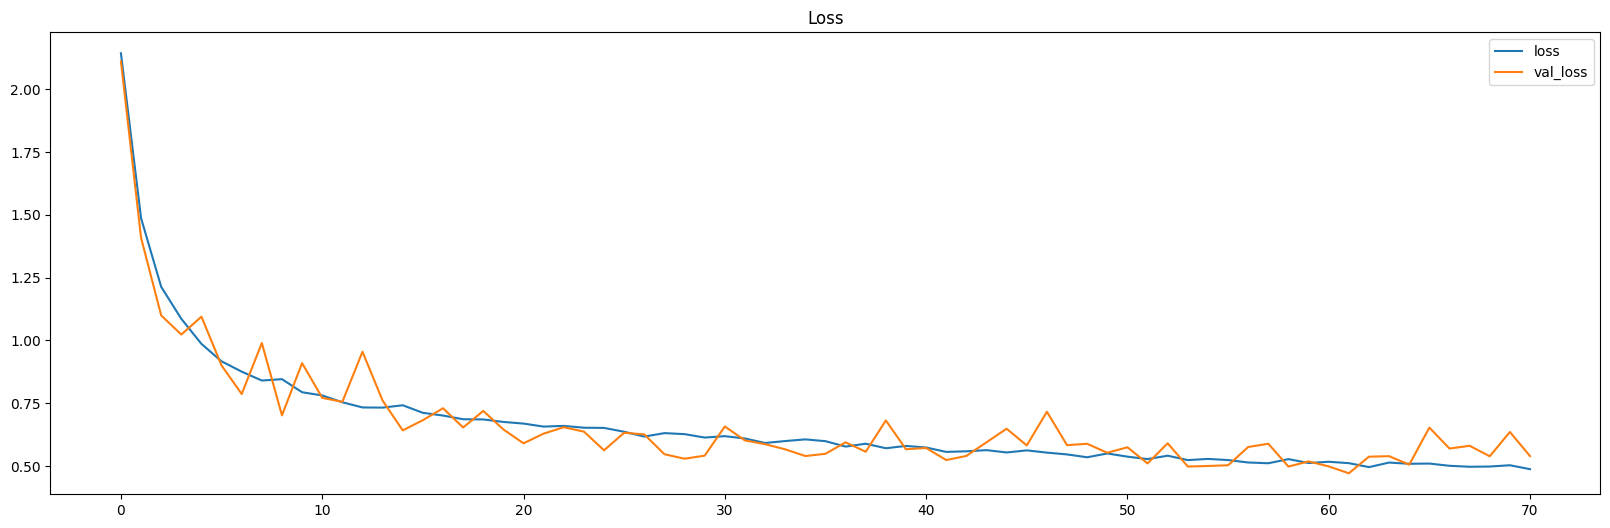

In [73]:
pd.DataFrame(Modelhis_4.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

**Pruebas con datos de Validación del conjuntro TRAIN**

Porcentaje de Accuracy de la prueba 4 con la división de datos de validación dentro de los datos de entrenamiento

In [74]:
print("Accuracy: ", Modelhis_4.history['accuracy'][-1])
print("Val_Accuracy: ", Modelhis_4.history['val_accuracy'][-1])

Accuracy:  0.9021918177604675
Val_Accuracy:  0.9005001187324524


## Resultados Prueba 4
Resultados con valores de **test** ajenos al conjunto de entrenamiento


In [75]:
# Predict the label of the test_images
Ypred4 = model4.predict(X_t/255.0)
Ypred4 = np.argmax(Ypred4,axis=1)

# Map the label
labels = MAP_CHARACTERS
pred = [labels[k] for k in Ypred4]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

28/28 [==============================] - 0s 9ms/step
The first 5 predictions: ['comic_book_guy', 'edna_krabappel', 'lisa_simpson', 'sideshow_bob', 'sideshow_bob']


In [76]:
#Accuracy con datos nuevos:
acc = accuracy_score(y_t, Ypred4)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 93.03%


In [77]:
Nombres = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson','charles_montgomery_burns',
           'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman','krusty_the_clown', 'lisa_simpson',
           'marge_simpson', 'milhouse_van_houten', 'moe_szyslak',
           'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']

In [78]:
class_report4 = classification_report(y_t, Ypred4, target_names=Nombres, zero_division=1)
print(class_report4)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.88      0.92        48
  apu_nahasapeemapetilon       0.96      0.98      0.97        50
            bart_simpson       0.76      0.90      0.83        50
charles_montgomery_burns       0.82      0.98      0.90        48
            chief_wiggum       0.98      0.96      0.97        50
          comic_book_guy       1.00      0.86      0.92        49
          edna_krabappel       0.96      0.90      0.93        50
           homer_simpson       0.87      0.94      0.90        50
           kent_brockman       1.00      1.00      1.00        50
        krusty_the_clown       1.00      0.98      0.99        50
            lisa_simpson       0.79      0.84      0.82        50
           marge_simpson       0.94      0.96      0.95        50
     milhouse_van_houten       0.94      0.96      0.95        49
             moe_szyslak       0.94      0.92      0.93        50
         

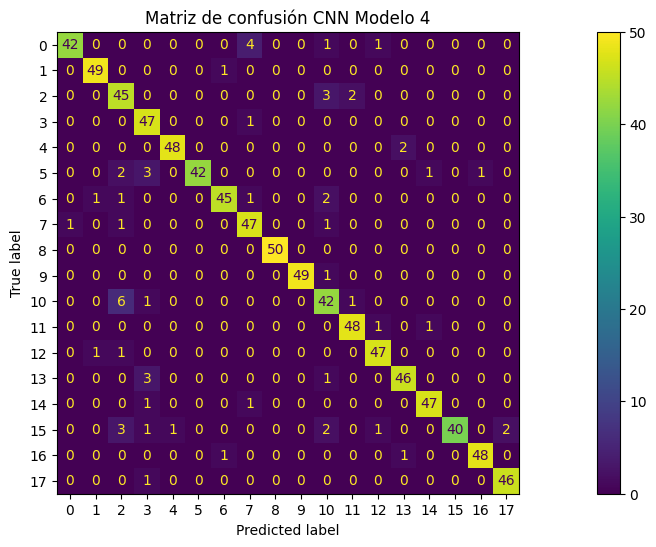

In [79]:
cm_nn4=confusion_matrix(
    y_true = y_t,
    y_pred = Ypred4
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn4)
disp.plot()
plt.title("Matriz de confusión CNN Modelo 4")
plt.show()

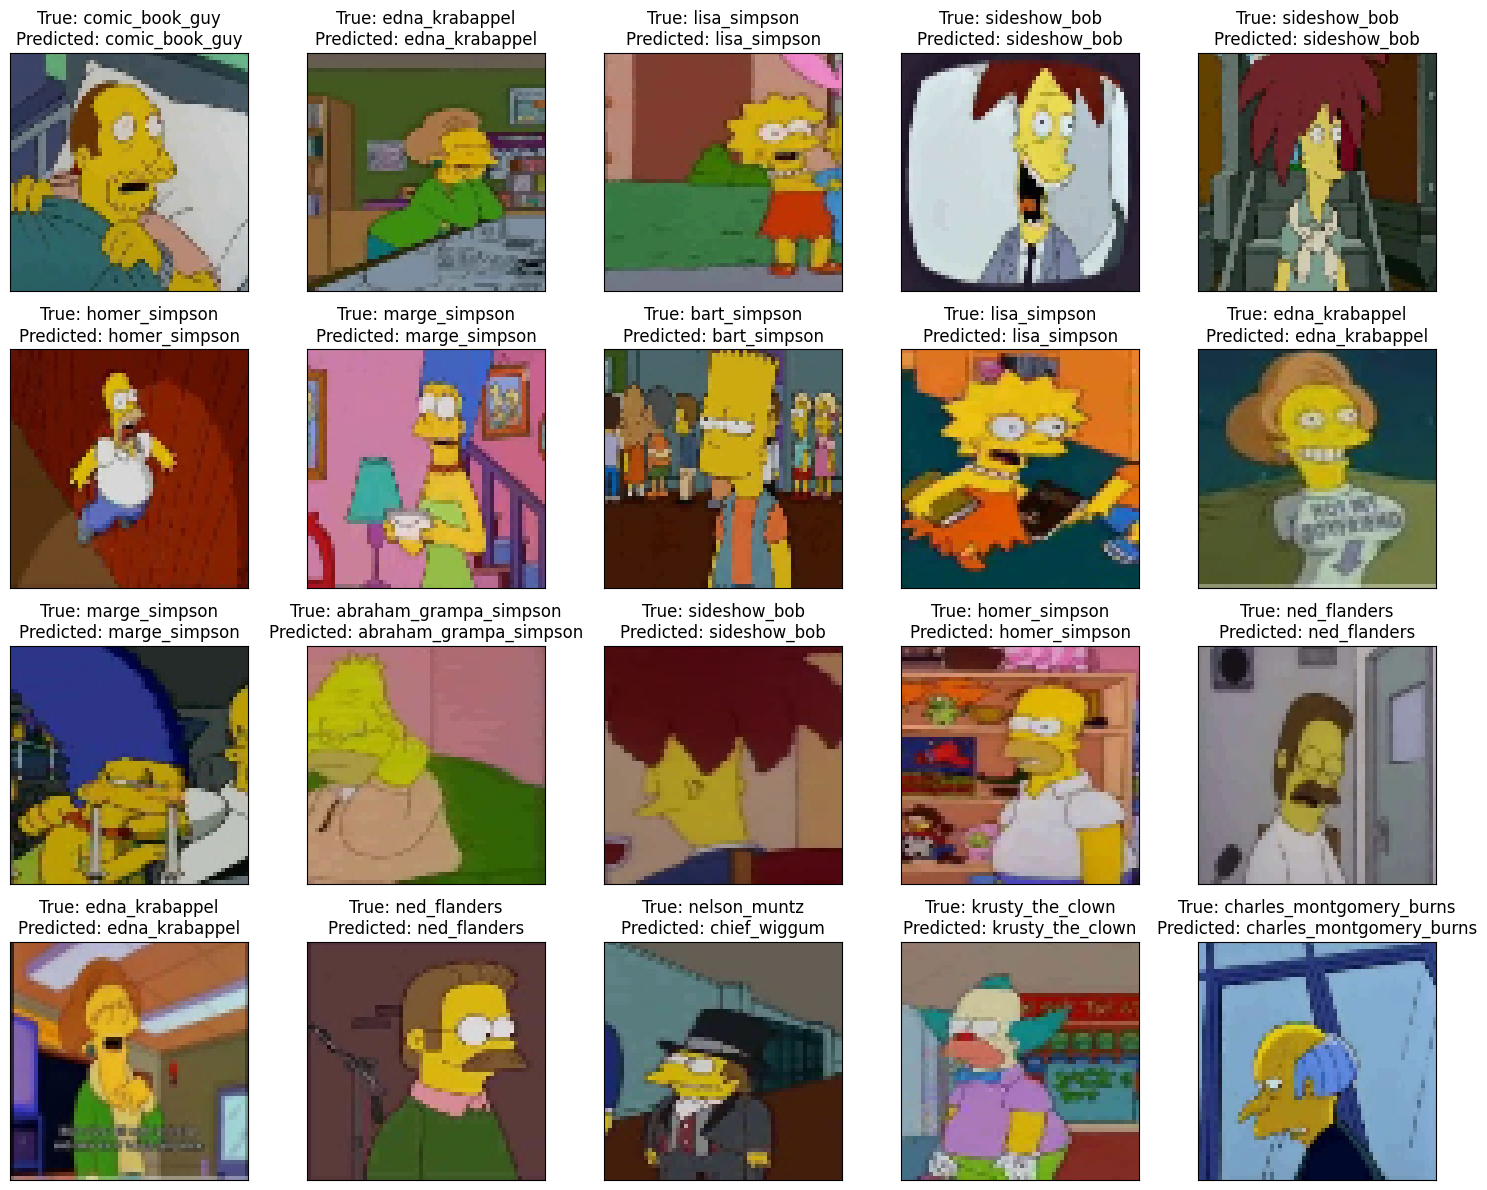

In [80]:
# Display 15 imágenes del conjunto de datos con sus etiquetas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flip(X_t[i], axis=-1))  # Utiliza X_test en lugar de plt.imread(test_df.Filepath.iloc[i])
    true_label = labels[y_t[i]]  # Convertir la etiqueta a una cadena
    predicted_label = labels[Ypred4[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

## Conclusión 4
Pese a que este modelo cuenta con mayores herramientas, su entrenamiento tardó mucho en converger, y si desempeño en test no es el mejor, se concluye que para usar un modelo más complejo se requiere una cantidad mayor de datos o bien el uso de Transfer Learning.

# Modelo 5: Modelo Fully Connected
**Caracteristicas**
* Reescalado
* Data Augmentation
* Modelo con capas Flatten y Dense



## División de datos de entrenamiento y test para todos los modelos propuestos

In [81]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.20, random_state=42)

In [83]:
ytrain5 = np.eye(len(MAP_CHARACTERS))[y_train5]
ytest5 = np.eye(len(MAP_CHARACTERS))[y_test5]

In [82]:
# Reescalado de datos 1
#Aumento de datos de entrenamiento
datagen5 = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

#Escalado de datos de test
testgen5 = ImageDataGenerator(rescale=1./255)


In [84]:
# Aplicar el aumento de datos a las variables de entrenamiento
#Ajustar los generadores
datagen5.fit(X_train5)
testgen5.fit(X_test5)

# Crear generador de lotes para entrenamiento con aumento de datos
augmented_train_data5 = datagen5.flow(X_train5, ytrain5, batch_size=32)

# Crear generador de lotes para prueba sin aumento de datos
test_data5 = testgen5.flow(X_test5, ytest5)

In [85]:
# Crear el modelo

model5 = tf.keras.models.Sequential([
    layers.Flatten(input_shape=(IMG_SIZE,IMG_SIZE,3)),
    layers.Dense(64, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(MAP_CHARACTERS), activation='softmax')
])


In [86]:
# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 10800)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                691264    
                                                                 
 dense_9 (Dense)             (None, 124)               8060      
                                                                 
 dense_10 (Dense)            (None, 256)               32000     
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 18)                1170      
                                                                 
Total params: 748,942
Trainable params: 748,942
Non-tr

In [88]:
# Entrenar el modelo
Modelhis_5= model5.fit(augmented_train_data5, epochs=30, validation_data=test_data5)

Epoch 1/30
475/475 [==============================] - 23s 41ms/step - loss: 2.7130 - accuracy: 0.1407 - val_loss: 2.5927 - val_accuracy: 0.1616
Epoch 2/30
475/475 [==============================] - 22s 45ms/step - loss: 2.6066 - accuracy: 0.1830 - val_loss: 2.4852 - val_accuracy: 0.2090
Epoch 3/30
475/475 [==============================] - 19s 40ms/step - loss: 2.5551 - accuracy: 0.1996 - val_loss: 2.4777 - val_accuracy: 0.2406
Epoch 4/30
475/475 [==============================] - 21s 43ms/step - loss: 2.5488 - accuracy: 0.1999 - val_loss: 2.4660 - val_accuracy: 0.2282
Epoch 5/30
475/475 [==============================] - 20s 41ms/step - loss: 2.5244 - accuracy: 0.2086 - val_loss: 2.3775 - val_accuracy: 0.2582
Epoch 6/30
475/475 [==============================] - 20s 43ms/step - loss: 2.5215 - accuracy: 0.2095 - val_loss: 2.4036 - val_accuracy: 0.2487
Epoch 7/30
475/475 [==============================] - 19s 40ms/step - loss: 2.5172 - accuracy: 0.2064 - val_loss: 2.4146 - val_accuracy:

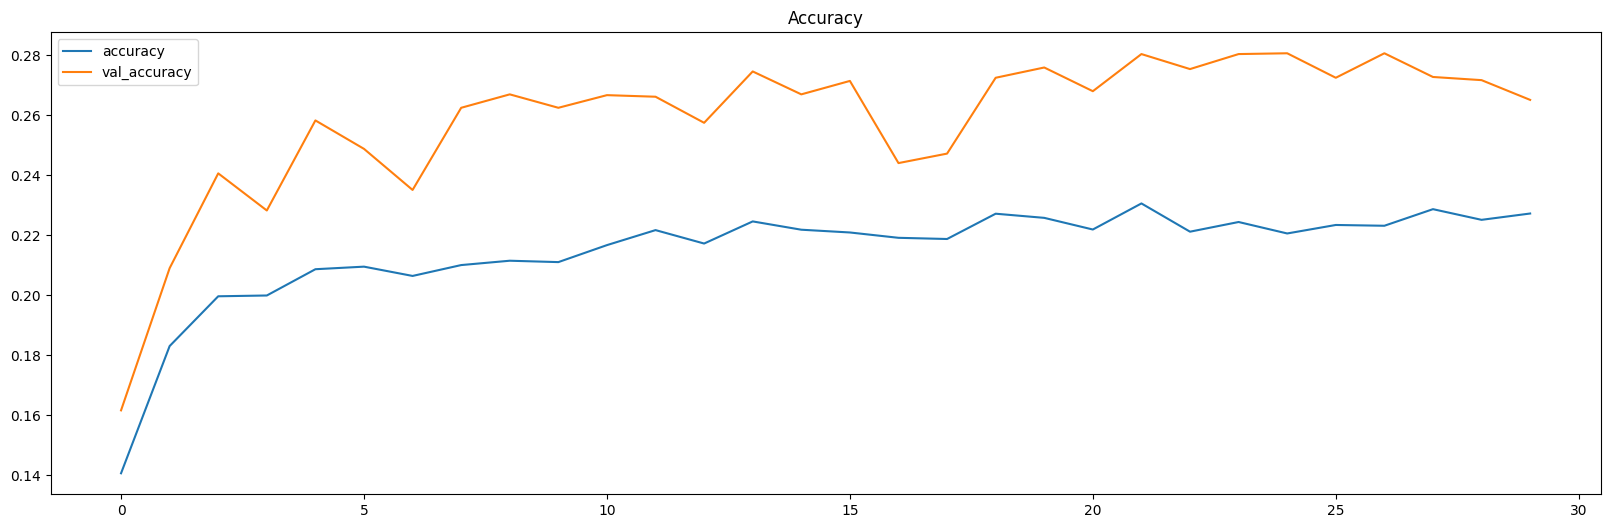

In [89]:
pd.DataFrame(Modelhis_5.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

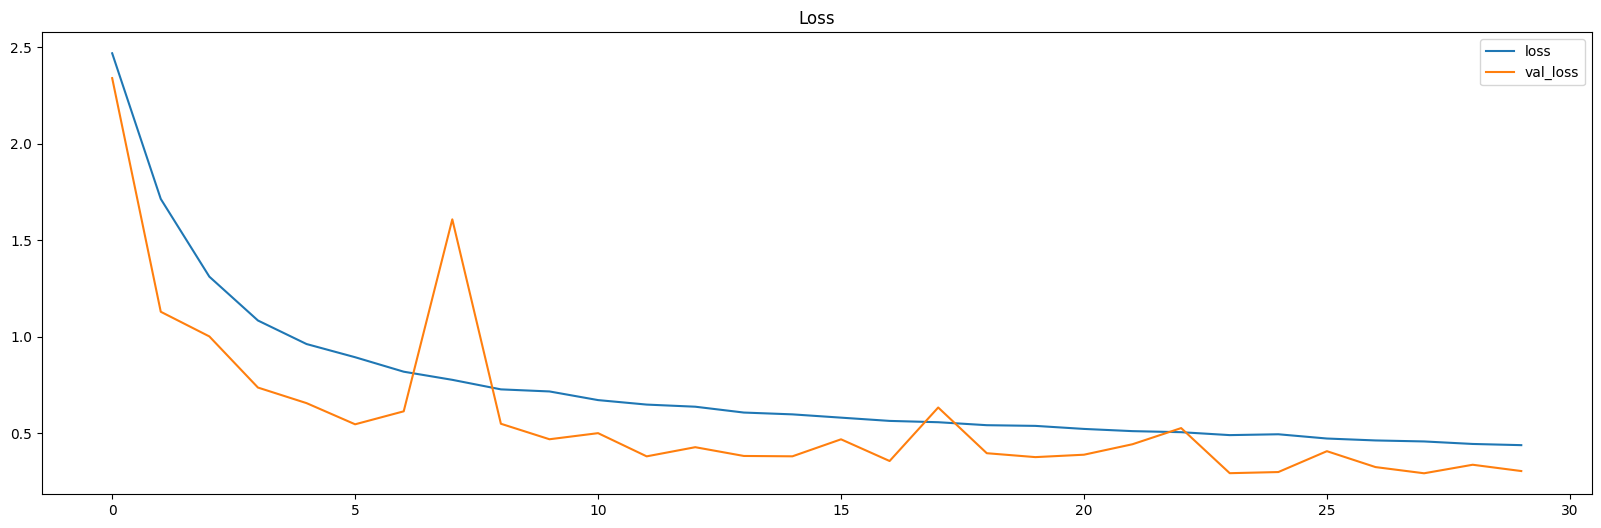

In [90]:
pd.DataFrame(Modelhis_3.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

Porcentaje de Accuracy de la prueba 3 con la división de datos de validación dentro de los datos de entrenamiento

In [91]:
print("Accuracy: ", Modelhis_5.history['accuracy'][-1])
print("Val_Accuracy: ", Modelhis_5.history['val_accuracy'][-1])

Accuracy:  0.2272098958492279
Val_Accuracy:  0.26506975293159485


## Resultados prueba 5

Prueba con datos de test nuevos



In [92]:
# Predict the label of the test_images
Ypred5 = model5.predict(X_t/255)
Ypred5 = np.argmax(Ypred5,axis=1)

# Map the label
labels = MAP_CHARACTERS
pred5 = [labels[k] for k in Ypred5]

# Display the result
print(f'The first 5 predictions: {pred5[:5]}')

28/28 [==============================] - 0s 2ms/step
The first 5 predictions: ['lisa_simpson', 'ned_flanders', 'ned_flanders', 'homer_simpson', 'moe_szyslak']


In [94]:
#Accuracy con datos nuevos:
acc = accuracy_score(y_t, Ypred5)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 22.92%


In [95]:
class_report = classification_report(y_t, Ypred5, target_names=Nombres, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.00      0.00      0.00        48
  apu_nahasapeemapetilon       0.47      0.18      0.26        50
            bart_simpson       0.09      0.12      0.10        50
charles_montgomery_burns       0.38      0.29      0.33        48
            chief_wiggum       0.27      0.52      0.36        50
          comic_book_guy       1.00      0.00      0.00        49
          edna_krabappel       0.64      0.14      0.23        50
           homer_simpson       0.15      0.38      0.22        50
           kent_brockman       1.00      0.00      0.00        50
        krusty_the_clown       0.31      0.38      0.34        50
            lisa_simpson       0.23      0.30      0.26        50
           marge_simpson       0.24      0.66      0.35        50
     milhouse_van_houten       1.00      0.00      0.00        49
             moe_szyslak       0.20      0.20      0.20        50
         

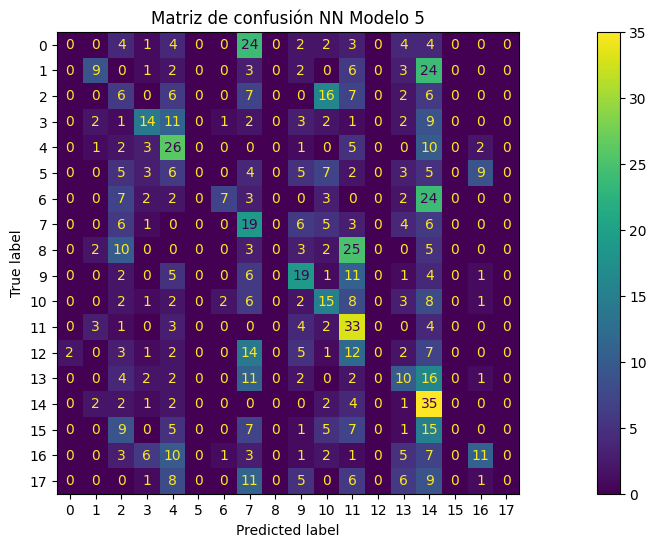

In [101]:
cm_nn5=confusion_matrix(
    y_true = y_t,
    y_pred = Ypred5
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn5)
disp.plot()
plt.title("Matriz de confusión NN Modelo 5")
plt.show()

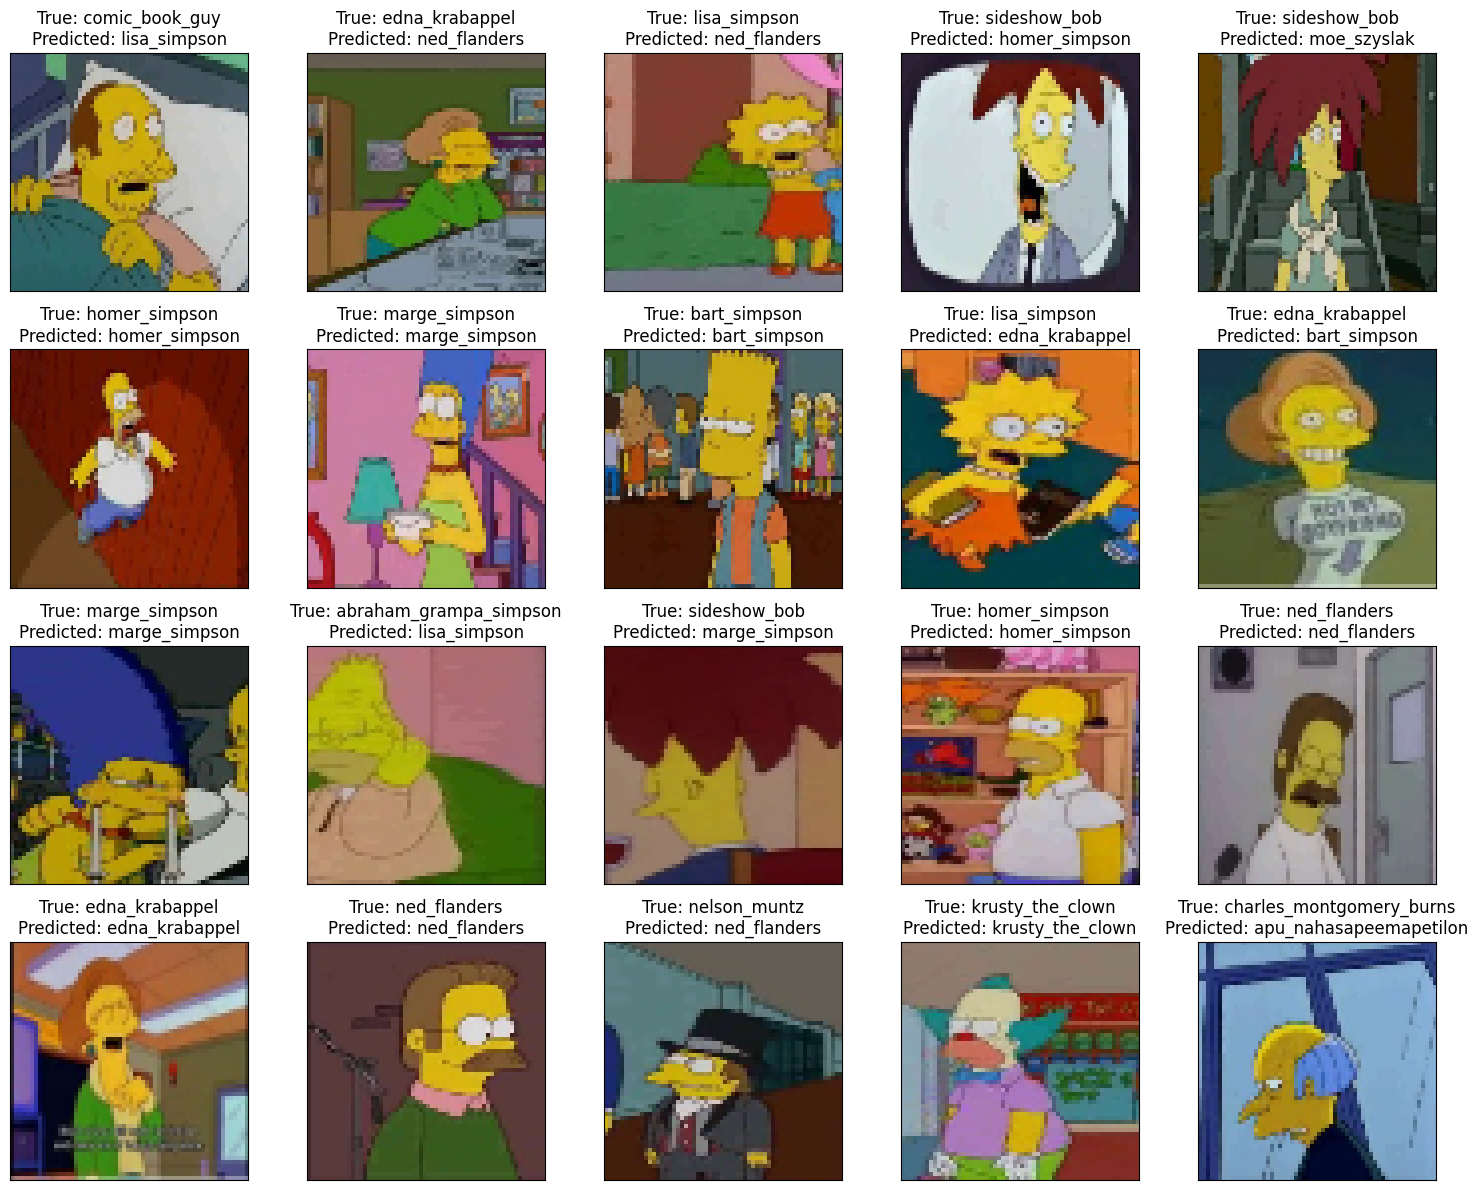

In [98]:
# Display 15 imágenes del conjunto de datos con sus etiquetas
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(np.flip(X_t[i], axis=-1))  # Utiliza X_test en lugar de plt.imread(test_df.Filepath.iloc[i])
    true_label = labels[y_t[i]]  # Convertir la etiqueta a una cadena
    predicted_label = labels[Ypred5[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()

##   Conclusión 5
No se recomienda un modelo Fully Connected ya que los parámetros a evaluar son demasiados dados en la capa Flatten y no llega a converger en ningún punto.

# Conclusión y descripción general de los modelos:


1.    Modelo Básico
  * Normalizado
  * Modelo básico sin dropout y batch normalization
  * Sin Data augmentation para analizar el rendimiento
  * **Accuracy de test: 94.61%**
  * Personaje con menor clasificación: homer_simpson precision: 86%

**Conclusión**: Modelo básico con buen desempeño en test pero deficiente en validación de entrenamiento

2.    Modelo mejorado
  * Normalizado
  * Sin Data Augmentation
  * Modelo con capas dropout y batch normalization
  * **Accuracy de test: 96.52%**
  * Personaje con menor clasificación: homer_simpson y ned_flanders prec: 89%

**Conclusión**: Buen modelo, gran ajuste, entrenamiento rápido, pero sin aumento de datos.

3.    Modelo 2 con Aumento de datos
  * Normalizado
  * Con Data Augmentation
  * Modelo con capas dropout y batch normalization
  * **Accuracy de test: 96.52%**
  * Personaje con menor clasificación: ned_flanders precision: 89%

**Conclusión**: **Modelo Recomendado** El modelo se ajusta con buena exactitud a los datos de test con buenos rendimientos en entrenamiento y considerando un aumento de datos en su estructura lo que da mejoras en el reconocimiento de patrones.

4.    Modelo con mayor complejidad y funciones
  * Normalizado
  * Modelo más complejo con dropout y batch normalization
  * Aplicando Data augmentation
  * Se aplica callback para detener el entrenamiento
  * Se aplica regularización L2
  * **Accuracy de test: 93.03%**
  * Personaje con menor clasificación: bart_simpson precision: 89%

**Conclusión**: Pese a que este modelo cuenta con mayores herramientas, su entrenamiento tardó mucho en converger, y si desempeño en test no es el mejor, se concluye que para usar un modelo más complejo se requiere una cantidad mayor de datos o bien el uso de Transfer Learning.

5.    Modelo Fully Connected
  * Normalizado
  * Data Augmentation
  * Modelo con capas Flatten y Dense
  * **Accuracy de test: 22.92%**
  * Personaje con menor clasificación: abraham_grampa_simpson precision: 0%

  **Conclusión**: No se recomienda un modelo Fully Connected ya que los parámetros a evaluar son demasiados dados en la capa Flatten y no llega a converger en ningún punto.